In [1]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm
import healpy as hp
import numpy.ma as ma
from healpy.sphtfunc import Alm
from uncertainties import ufloat
from uncertainties.umath import *  
from mpmath import spherharm
from scipy.special import sph_harm
from scipy.special import lpn
from scipy.special import legendre
from multiprocessing import Pool
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)


# 1. Load some example data 
_Gaia_ QSOs.

In [3]:
nside = 64
lmax = 3*nside - 1

In [4]:
# Load quasars into a DataFrame
quasars_pd = pd.read_csv("../data/quasars_phot.csv")

In [5]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values

In [6]:
pm_ra_cosdec = quasars_pd['pmra'].values*np.cos(quasars_pd['dec'].values*np.pi/180.)
pm_dec = quasars_pd['pmdec'].values

In [7]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
             dec=dec*u.deg, 
             pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, 
             pm_dec=pm_dec*u.mas/u.yr,
             frame='icrs')

In [8]:
quasars_gal = quasars_icrs.transform_to('galactic')

In [9]:
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

pm_l_err = quasars_pd['pmra_error']
pm_b_err = quasars_pd['pmdec_error']

In [10]:
qpix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

quasars_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))

pm_l_noise_map = np.zeros(hp.nside2npix(nside))
pm_b_noise_map = np.zeros(hp.nside2npix(nside))

In [11]:
for idx, ipix in enumerate(tqdm_notebook((qpix))):
    quasars_map[ipix] += 1
    pm_l_map[ipix] += pm_l_gal[idx]
    pm_b_map[ipix] += pm_b_gal[idx]
    
    pm_l_noise_map[ipix] += pm_l_err[idx]
    pm_b_noise_map[ipix] += pm_b_err[idx]

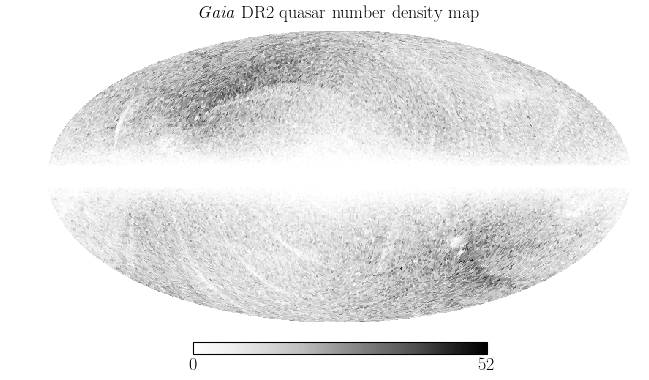

In [45]:
hp.mollview(quasars_map, title='\emph{Gaia} DR2 quasar number density map', cmap=cm.Greys)
plt.savefig("/Users/smsharma/Desktop/qso.pdf")

In [17]:
pm_l_gal_uct = [ufloat(pm_l_gal[i],pm_l_err[i]) for i in tqdm_notebook(range(len(qpix)))]
pm_b_gal_uct = [ufloat(pm_b_gal[i],pm_b_err[i]) for i in tqdm_notebook(range(len(qpix)))]

In [18]:
pm_v_gal_uct = [sqrt(pm_l_gal_uct[i]**2 + pm_b_gal_uct[i]**2) for i in tqdm_notebook(range(len(qpix)))]

In [19]:
pm_v_gal = [pm_v_gal_uct[i].nominal_value for i in tqdm_notebook(range(len(qpix)))]
pm_v_noise_gal = [pm_v_gal_uct[i].std_dev for i in tqdm_notebook(range(len(qpix)))]

In [20]:
pm_v_map_aux = [[] for i in range(hp.nside2npix(nside))]
pm_v_noise_map_aux = [[] for i in range(hp.nside2npix(nside))]

In [21]:
for idx, ipix in enumerate(tqdm_notebook((qpix))):
    pm_v_map_aux[ipix].append(pm_v_gal[idx])
    pm_v_noise_map_aux[ipix].append(pm_v_noise_gal[idx])

In [22]:
pm_v_map = np.zeros(hp.nside2npix(nside))
pm_v_noise_map = np.zeros(hp.nside2npix(nside))

In [23]:
for ipix in tqdm_notebook(range(hp.nside2npix(nside))):
    v_ary = np.array(pm_v_map_aux[ipix])
    dv_ary = np.array(pm_v_noise_map_aux[ipix])
    sigma2 = 1/np.sum(1/dv_ary**2)
    ewm = sigma2*np.sum(v_ary/dv_ary**2)
    pm_v_map[ipix] = ewm
    pm_v_noise_map[ipix] = np.sqrt(sigma2)

/Users/smsharma/.conda/envs/StrongLensing-Inference/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/Users/smsharma/.conda/envs/StrongLensing-Inference/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


/Users/smsharma/.conda/envs/StrongLensing-Inference/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


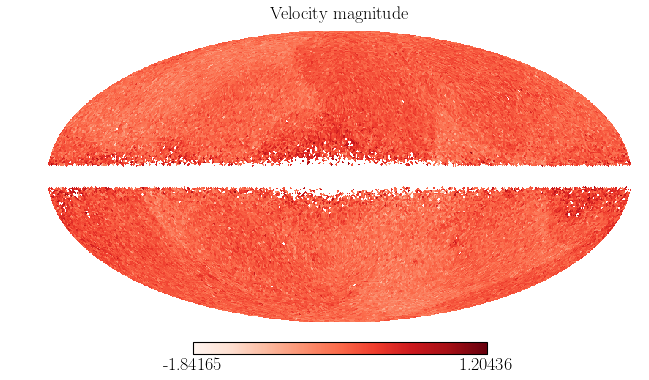

In [59]:
from matplotlib import cm
pm_v_map = np.nan_to_num(pm_v_map)
hp.mollview(np.log10(pm_v_map), title="Velocity magnitude", cmap=cm.Reds)
plt.savefig("/Users/smsharma/Desktop/vmag.pdf")

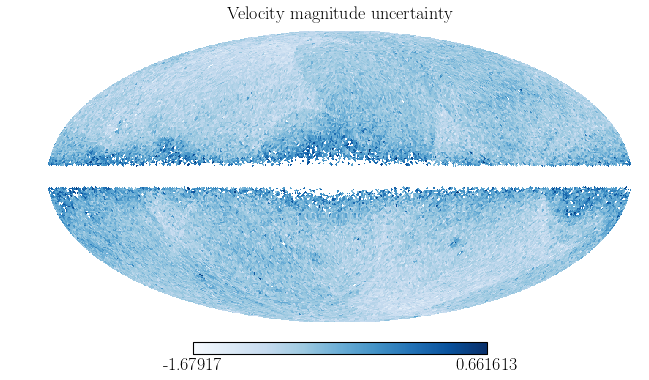

In [46]:
hp.mollview(np.log10(pm_v_noise_map), title="Velocity magnitude uncertainty", cmap=cm.Blues)
plt.savefig("/Users/smsharma/Desktop/sigmavmag.pdf")

# Cluster run

In [208]:
C = np.diag(pm_v_noise_map**2)
Cinv = np.diag(1/pm_v_noise_map**2)

In [209]:
vecs = np.transpose(hp.pix2vec(nside, np.arange(hp.nside2npix(nside))))
dp = np.einsum("ij,kj->ik",vecs, vecs)

def P_l(l):    
    lp = legendre(l)
    return (2*l + 1)/(4*np.pi)*lp(dp)

In [48]:
np.save('Fisher/data/dp.npy', dp)
np.save('Fisher/data/Cinv.npy', Cinv)

In [4]:
dp = np.load('Fisher/data/dp.npy')
Cinv = np.load('Fisher/data/Cinv.npy')

In [9]:
# # Pre-save P_l

# def save_Pl(l):
#     np.save("/scratch/sm8383/P_l/P_l_"+str(l), P_l(l))
    
# pool = Pool(16)                         # Crxate a multiprocessing Pool
# pool.map(save_Pl, np.arange(0, lmax + 1))  # process data_inputs iterable with pool

In [10]:
def get_fisher(llp):
    l_1, l_2 = llp
    filename = "Fisher/output/f_"+str(l_1)+"_"+str(l_2)+".npy"
    the_file = Path(filename)
    if the_file.is_file():
        print("Exists", l_1, l_2)
    else:
        print("Doing", l_1, l_2)
        P_l_1 = np.load("/scratch/sm8383/P_l/P_l_"+str(l_1)+".npy")
        P_l_2 = np.load("/scratch/sm8383/P_l/P_l_"+str(l_2)+".npy")
        np.save(filename, 0.5*np.einsum("ij,ji",np.multiply(np.diag(Cinv)[:,None], P_l_1),np.multiply(np.diag(Cinv)[:,None], P_l_2)))

In [138]:
# Presave llprime array

In [11]:
llp_ary = []
for il in range(lmax + 1):
    for jl in range(il + 1):
        filename = "Fisher/output/f_"+str(il)+"_"+str(jl)+".npy"
        the_file = Path(filename)
        if not the_file.is_file():
            llp_ary.append([il,jl])

In [47]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [54]:
np.save("Fisher/data/llp_ary.npy", list(chunks(llp_ary, 100)))

In [96]:
# # Cluster run

# from multiprocessing import Pool

# pool = Pool(16)                         # Create a multiprocessing Pool
# pool.map(get_fisher, llp_ary[i])  # process data_inputs iterable with pool

In [ ]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [97]:
F = np.zeros((lmax, lmax))
for il in range(1, lmax):
    for jl in range(il+1):
        F[il][jl] = np.load("Fisher/output/f_"+str(il)+"_"+str(jl)+".npy")
        
F = symmetrize(F)

In [101]:
Cov = np.linalg.inv(F)

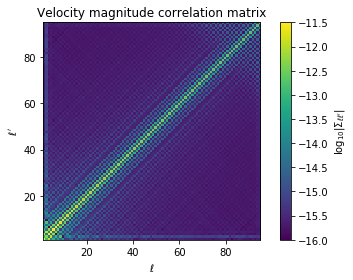

In [136]:
plt.imshow(np.log10(np.abs(Cov[1:,1:])),vmin=-16,vmax=-11.5,origin='lower',extent=[1,lmax,1,lmax])
plt.xlabel("$\ell$")
plt.ylabel("$\ell'$")
plt.title("Velocity magnitude correlation matrix")
cbar = plt.colorbar() 
cbar.set_label("$\log_{10}|\Sigma_{\ell\ell'}|$")
plt.tight_layout()
plt.savefig("cov_mat.pdf")
plt.savefig("cov_mat.png")

# 2. Anafast estimates
Some baselines.

In [22]:
lmax = 3*nside - 1
alm_qso_anafast = hp.map2alm(quasars_map, lmax=lmax)

In [23]:
l = 3
m = 2
alm_qso_anafast[Alm.getidx(lmax, l, m)]

(-0.47447167415193153+1.853227716659314j)

# 3. Brute force estimate

Estimate as integral $\rightarrow$ sum over pixels.

In [ ]:
def Ylm(l, m, theta, phi): 
    """
    Redefine spherical harmonics from scipy.special
    to match physics convention.
    
    Parameters
    ----------
    l : int, array_like
        Degree of the harmonic (int); ``l >= 0``.
    m : int, array_like
        Order of the harmonic (int); ``|m| <= l``.
    theta : array_like
        Polar (colatitudinal) coordinate; must be in ``[0, pi]``.
    phi : array_like
        Azimuthal (longitudinal) coordinate; must be in ``[0, 2*pi]``.
    
    Returns
    -------
    Ylm : complex float
       The harmonic Ylm sampled at ``theta`` and ``phi``.
    """
    if np.abs(m) > l:
        Ylm = 0
    else:
        Ylm = sph_harm(m, l, phi, theta) # Perform redefinition
#         Ylm = spherharm(l, m, theta, phi)
    return Ylm

def map2alm(the_map, l, m):
    nside = hp.npix2nside(len(the_map))
    alm = 0
    domega = hp.nside2pixarea(nside)
    for ipix in range(len(the_map)):
        theta, phi = hp.pix2ang(nside, ipix)
        alm += the_map[ipix]*np.conjugate(Ylm(l, m, theta, phi))*domega
    return alm


In [ ]:
map2alm(quasars_map, l, m)

Matches the above, so far so good...

# 4. "Whole sphere data" from Dahlen

Using the simpler formalism in Sec. 4 of Dahlen et al.

In [ ]:
l = 1

In [ ]:
d = quasars_map
vecs = np.transpose(hp.pix2vec(nside, np.arange(len(d))))
dp = np.einsum("ij,kj->ik",vecs, vecs)
lp = legendre(l)
P_l = (2*l + 1)/(4*np.pi)*lp(dp)

nside = hp.npix2nside(len(d))
domega = hp.nside2pixarea(nside)

In [ ]:
hp.anafast(quasars_map)[l]

In [ ]:
domega**2/(2*l+1)*np.einsum("i,ij,j", d, P_l, d)

Good...

Alternatively,

In [ ]:
C = np.outer(d, d)

In [ ]:
matmul = np.matmul(C, P_l)

In [ ]:
domega**2/(2*l+1)*np.trace(matmul)

Viz data covariance matrix:

In [ ]:
plt.imshow(C)

In [ ]:
np.linalg.inv(C)

# 5. Velocity magnitudes

In [56]:
mat = np.random.rand(100,100)
np.linalg.inv(mat)

array([[ 2.24276294,  0.02114863,  0.86139153, ...,  0.59779429,
         0.81791868,  2.23174316],
       [-5.21221173, -0.89550035, -2.71282876, ..., -2.27652106,
        -1.31873159, -7.14163956],
       [ 0.80435585, -0.36754657, -0.0564188 , ...,  0.39200395,
         0.16508815,  0.88380355],
       ...,
       [-0.3375066 , -0.12524398, -0.21505222, ..., -0.40526797,
         0.1737971 , -1.01771128],
       [-2.57301602, -0.54656734, -1.21546229, ..., -1.09323543,
        -0.71375607, -3.63539802],
       [ 2.82597779,  0.47588789,  1.41918475, ...,  1.35015339,
         0.74739961,  4.04497218]])